<a href="https://colab.research.google.com/github/JamesJokDutAkuei/Malaria_Diagnosis_Transfer_Learning/blob/main/Malaria_Diagnosis_CNN_Group6_EvenNumber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [ ]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/"

In [1]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

## Populating namespaces

In [2]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [3]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

## Prepare DataSet

### *Download* DataSet

In [4]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-05 18:33:32--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.165.102.109, 3.165.102.126, 3.165.102.59, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.165.102.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   307MB/s    in 1.1s    

2025-10-05 18:33:34 (307 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  sample_data


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


# InceptionV3 Transfer Learning for Malaria Diagnosis
# Author: James Jok Dut Akuei
# Model: InceptionV3 with Transfer Learning

This notebook implements transfer learning using InceptionV3,
an efficient architecture with inception modules that parallelize
different filter sizes. InceptionV3 was chosen for:
- Lower computational cost than ResNet/VGG
- Strong performance on medical images
- Efficient multi-scale feature extraction
- Only 23.9M parameters (lighter than ResNet50's 25.6M)

Two experiments:
1. Experiment 1: Frozen base with minimal layers
2. Experiment 2: Fine-tuning with enhanced augmentation

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU:", tf.test.gpu_device_name())



TensorFlow version: 2.19.0
GPU: /device:GPU:0


# DATA PREPARATION AND SPLITTING

In [11]:
print("\nSetting up data paths...")
TRAIN_DIR = './train'
TEST_DIR = './test'
IMG_SIZE = (299, 299)  # InceptionV3 requires 299x299
BATCH_SIZE = 32
EPOCHS_EXP1 = 5  # Experiment 1 epochs
EPOCHS_EXP2_PHASE1 = 5  # Phase 1 epochs
EPOCHS_EXP2_PHASE2 = 5  # Phase 2 epochs


Setting up data paths...


In [12]:
# ============================================================================
# DATA PREPARATION - Run this FIRST in new Colab
# ============================================================================

import os
import shutil
import random

# Define paths
ai_project = '.'
cell_images_dir = os.path.join(ai_project, 'cell_images')
TRAIN_DIR = os.path.join(ai_project, 'train')
TEST_DIR = os.path.join(ai_project, 'test')

# Download dataset if needed
if not os.path.exists(cell_images_dir):
    print("Downloading dataset...")
    !wget -q https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip -q cell_images.zip
    !rm cell_images.zip
    print("✓ Dataset downloaded")

# Create train/test split
if not os.path.exists(TRAIN_DIR) or not os.path.exists(TEST_DIR):
    print("\nCreating train/test split...")

    # Create directories
    for split_dir in [TRAIN_DIR, TEST_DIR]:
        for class_name in ['Parasitized', 'Uninfected']:
            os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

    # Split data 80/20
    random.seed(42)
    for class_name in ['Parasitized', 'Uninfected']:
        src_path = os.path.join(cell_images_dir, class_name)
        images = [f for f in os.listdir(src_path) if f.endswith(('.png', '.jpg'))]
        random.shuffle(images)

        split_idx = int(len(images) * 0.8)
        train_imgs = images[:split_idx]
        test_imgs = images[split_idx:]

        print(f"{class_name}: {len(train_imgs)} train, {len(test_imgs)} test")

        # Copy to train
        for img in train_imgs:
            shutil.copy2(os.path.join(src_path, img),
                        os.path.join(TRAIN_DIR, class_name, img))

        # Copy to test
        for img in test_imgs:
            shutil.copy2(os.path.join(src_path, img),
                        os.path.join(TEST_DIR, class_name, img))

    print("\n✓ Data split complete!")

print("\nData ready for training:")
print(f"Train: {TRAIN_DIR}")
print(f"Test: {TEST_DIR}")


Data ready for training:
Train: ./train
Test: ./test


# EXPERIMENT 1: Frozen Base with Minimal Layers

In [13]:
print("\n" + "="*80)
print("EXPERIMENT 1: InceptionV3 with Frozen Base")
print("="*80)

# Basic data augmentation
train_datagen_exp1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator_exp1 = train_datagen_exp1.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator_exp1 = train_datagen_exp1.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"\nData Summary:")
print(f"Training: {train_generator_exp1.samples}")
print(f"Validation: {val_generator_exp1.samples}")
print(f"Test: {test_generator.samples}")

# Build simplified model
def build_inceptionv3_simple():
    """
    Build InceptionV3 with minimal classification layers.
    Reduces complexity compared to typical architectures.
    """
    # Load pre-trained InceptionV3
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )

    # Freeze all base layers
    base_model.trainable = False

    # Minimal classification head - only 2 layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)  # Single dense layer
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Create model
model_exp1 = build_inceptionv3_simple()

# Compile
model_exp1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print("\nModel Architecture:")
total_params = model_exp1.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model_exp1.trainable_weights])
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")

# Callbacks
callbacks_exp1 = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'inceptionv3_exp1_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train
print("\nTraining Experiment 1...")
history_exp1 = model_exp1.fit(
    train_generator_exp1,
    validation_data=val_generator_exp1,
    epochs=EPOCHS_EXP1,
    callbacks=callbacks_exp1,
    verbose=1
)

# Evaluate
print("\nEvaluating Experiment 1...")
test_generator.reset()
test_results = model_exp1.evaluate(test_generator, verbose=1)
test_acc_exp1, test_prec_exp1, test_rec_exp1, test_auc_exp1 = test_results[1:]

print(f"\nExperiment 1 Test Results:")
print(f"Accuracy:  {test_acc_exp1:.4f}")
print(f"Precision: {test_prec_exp1:.4f}")
print(f"Recall:    {test_rec_exp1:.4f}")
print(f"AUC:       {test_auc_exp1:.4f}")


EXPERIMENT 1: InceptionV3 with Frozen Base
Found 17638 images belonging to 2 classes.
Found 4408 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.

Data Summary:
Training: 17638
Validation: 4408
Test: 5512
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

Model Architecture:
Total parameters: 22,065,185
Trainable parameters: 262,401
Non-trainable parameters: 21,802,784

Training Experiment 1...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.7999 - auc: 0.8727 - loss: 0.4392 - precision: 0.7965 - recall: 0.8026
Epoch 1: val_accuracy improved from -inf to 0.89315, saving model to inceptionv3_exp1_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 537s 933ms/step - accuracy: 0.8000 - auc: 0.8728 - loss: 0.4390 - precision: 0.7965 - recall: 0.8027 - val_accuracy: 0.8931 - val_auc: 0.9569 - val_loss: 0.2726 - val_precision: 0.8819 - val_recall: 0.9079 - learning_rate: 0.0010
Epoch 2/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.8768 - auc: 0.9439 - loss: 0.2980 - precision: 0.8641 - recall: 0.8956
Epoch 2: val_accuracy did not improve from 0.89315
552/552 ━━━━━━━━━━━━━━━━━━━━ 475s 861ms/step - accuracy: 0.8768 - auc: 0.9439 - loss: 0.2980 - precision: 0.8641 - recall: 0.8956 - val_accuracy: 0.8920 - val_auc: 0.9619 - val_loss: 0.2684 - val_precision: 0.9079 - val_recall: 0.8725 - learning_rate: 0.0010
Epoch 3/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.8838 - auc: 0.9485 - loss: 0.2868 - precision: 0.8711 - recall: 0.8997
Epoch 3: val_accuracy improved from 0.89315 to 0.89655, saving model to inceptionv3_exp1_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 475s 860ms/step - accuracy: 0.8839 - auc: 0.9485 - loss: 0.2868 - precision: 0.8711 - recall: 0.8997 - val_accuracy: 0.8966 - val_auc: 0.9605 - val_loss: 0.2548 - val_precision: 0.9024 - val_recall: 0.8893 - learning_rate: 0.0010
Epoch 4/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.8936 - auc: 0.9535 - loss: 0.2717 - precision: 0.8797 - recall: 0.9106
Epoch 4: val_accuracy did not improve from 0.89655
552/552 ━━━━━━━━━━━━━━━━━━━━ 472s 856ms/step - accuracy: 0.8936 - auc: 0.9535 - loss: 0.2717 - precision: 0.8796 - recall: 0.9106 - val_accuracy: 0.8927 - val_auc: 0.9588 - val_loss: 0.2630 - val_precision: 0.8543 - val_recall: 0.9469 - learning_rate: 0.0010
Epoch 5/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.8907 - auc: 0.9542 - loss: 0.2704 - precision: 0.8790 - recall: 0.9098
Epoch 5: val_accuracy improved from 0.89655 to 0.90245, saving model to inceptionv3_exp1_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 474s 859ms/step - accuracy: 0.8907 - auc: 0.9542 - loss: 0.2704 - precision: 0.8790 - recall: 0.9098 - val_accuracy: 0.9025 - val_auc: 0.9605 - val_loss: 0.2538 - val_precision: 0.9050 - val_recall: 0.8993 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.

Evaluating Experiment 1...
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 165ms/step - accuracy: 0.9293 - auc: 0.4944 - loss: 0.1680 - precision: 0.4090 - recall: 0.4678

Experiment 1 Test Results:
Accuracy:  0.9245
Precision: 0.9305
Recall:    0.9176
AUC:       0.9766


# EXPERIMENT 2: Fine-tuning with Enhanced Augmentation

In [14]:
print("\n" + "="*80)
print("EXPERIMENT 2: InceptionV3 with Fine-tuning")
print("="*80)

# Enhanced augmentation
train_datagen_exp2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

# Load data
train_generator_exp2 = train_datagen_exp2.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator_exp2 = train_datagen_exp2.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Build model with slightly more capacity for fine-tuning
def build_inceptionv3_finetune():
    """
    Build InceptionV3 with slightly more capacity.
    Still keeps architecture minimal.
    """
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )

    base_model.trainable = False

    # Slightly larger head for fine-tuning
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model, base_model

model_exp2, base_model_exp2 = build_inceptionv3_finetune()

# Phase 1: Train with frozen base
print("\nPhase 1: Training with frozen base...")
model_exp2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

history_phase1 = model_exp2.fit(
    train_generator_exp2,
    validation_data=val_generator_exp2,
    epochs=EPOCHS_EXP2_PHASE1,
    callbacks=[
        EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True, mode='max')
    ],
    verbose=1
)

# Phase 2: Fine-tune top layers
print("\nPhase 2: Fine-tuning top layers...")
base_model_exp2.trainable = True

# Freeze all except last 50 layers
for layer in base_model_exp2.layers[:-50]:
    layer.trainable = False

trainable_layers = sum([layer.trainable for layer in base_model_exp2.layers])
print(f"Trainable layers in base: {trainable_layers}/{len(base_model_exp2.layers)}")

# Recompile with lower learning rate
model_exp2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

callbacks_exp2 = [
    EarlyStopping(
        monitor='val_auc',
        patience=8,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=4,
        min_lr=1e-8,
        verbose=1
    ),
    ModelCheckpoint(
        'inceptionv3_exp2_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

history_phase2 = model_exp2.fit(
    train_generator_exp2,
    validation_data=val_generator_exp2,
    epochs=EPOCHS_EXP2_PHASE2,
    callbacks=callbacks_exp2,
    verbose=1
)

# Combine histories
history_exp2 = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss'],
    'auc': history_phase1.history['auc'] + history_phase2.history['auc'],
    'val_auc': history_phase1.history['val_auc'] + history_phase2.history['val_auc'],
    'precision': history_phase1.history['precision'] + history_phase2.history['precision'],
    'val_precision': history_phase1.history['val_precision'] + history_phase2.history['val_precision'],
    'recall': history_phase1.history['recall'] + history_phase2.history['recall'],
    'val_recall': history_phase1.history['val_recall'] + history_phase2.history['val_recall']
}

# Evaluate
print("\nEvaluating Experiment 2...")
test_generator.reset()
test_results = model_exp2.evaluate(test_generator, verbose=1)
test_acc_exp2, test_prec_exp2, test_rec_exp2, test_auc_exp2 = test_results[1:]

print(f"\nExperiment 2 Test Results:")
print(f"Accuracy:  {test_acc_exp2:.4f}")
print(f"Precision: {test_prec_exp2:.4f}")
print(f"Recall:    {test_rec_exp2:.4f}")
print(f"AUC:       {test_auc_exp2:.4f}")


EXPERIMENT 2: InceptionV3 with Fine-tuning
Found 17638 images belonging to 2 classes.
Found 4408 images belonging to 2 classes.

Phase 1: Training with frozen base...
Epoch 1/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 570s 1s/step - accuracy: 0.7362 - auc: 0.8117 - loss: 0.5319 - precision: 0.7308 - recall: 0.7494 - val_accuracy: 0.8768 - val_auc: 0.9405 - val_loss: 0.3179 - val_precision: 0.8542 - val_recall: 0.9088
Epoch 2/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 529s 959ms/step - accuracy: 0.8496 - auc: 0.9202 - loss: 0.3573 - precision: 0.8313 - recall: 0.8760 - val_accuracy: 0.8668 - val_auc: 0.9385 - val_loss: 0.3116 - val_precision: 0.8293 - val_recall: 0.9238
Epoch 3/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 530s 959ms/step - accuracy: 0.8582 - auc: 0.9260 - loss: 0.3427 - precision: 0.8388 - recall: 0.8853 - val_accuracy: 0.8793 - val_auc: 0.9414 - val_loss: 0.3204 - val_precision: 0.8641 - val_recall: 0.9002
Epoch 4/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 535s 969ms/step - accuracy: 0.8592 - auc: 0.9289 - loss: 0.33

552/552 ━━━━━━━━━━━━━━━━━━━━ 591s 1s/step - accuracy: 0.8907 - auc: 0.9496 - loss: 0.2840 - precision: 0.8737 - recall: 0.9159 - val_accuracy: 0.9188 - val_auc: 0.9669 - val_loss: 0.2211 - val_precision: 0.8921 - val_recall: 0.9528 - learning_rate: 1.0000e-04
Epoch 2/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.9261 - auc: 0.9696 - loss: 0.2109 - precision: 0.9027 - recall: 0.9574
Epoch 2: val_accuracy improved from 0.91878 to 0.92945, saving model to inceptionv3_exp2_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 548s 993ms/step - accuracy: 0.9261 - auc: 0.9696 - loss: 0.2109 - precision: 0.9027 - recall: 0.9574 - val_accuracy: 0.9294 - val_auc: 0.9697 - val_loss: 0.2068 - val_precision: 0.9071 - val_recall: 0.9569 - learning_rate: 1.0000e-04
Epoch 3/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.9307 - auc: 0.9748 - loss: 0.1907 - precision: 0.9080 - recall: 0.9585
Epoch 3: val_accuracy improved from 0.92945 to 0.93126, saving model to inceptionv3_exp2_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 551s 998ms/step - accuracy: 0.9307 - auc: 0.9748 - loss: 0.1907 - precision: 0.9080 - recall: 0.9585 - val_accuracy: 0.9313 - val_auc: 0.9692 - val_loss: 0.2027 - val_precision: 0.9081 - val_recall: 0.9596 - learning_rate: 1.0000e-04
Epoch 4/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.9369 - auc: 0.9763 - loss: 0.1822 - precision: 0.9133 - recall: 0.9641
Epoch 4: val_accuracy did not improve from 0.93126
552/552 ━━━━━━━━━━━━━━━━━━━━ 545s 987ms/step - accuracy: 0.9369 - auc: 0.9763 - loss: 0.1822 - precision: 0.9133 - recall: 0.9641 - val_accuracy: 0.9226 - val_auc: 0.9678 - val_loss: 0.2190 - val_precision: 0.8932 - val_recall: 0.9601 - learning_rate: 1.0000e-04
Epoch 5/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.9356 - auc: 0.9758 - loss: 0.1846 - precision: 0.9125 - recall: 0.9622
Epoch 5: val_accuracy improved from 0.93126 to 0.93444, saving model to inceptionv3_exp2_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 532s 964ms/step - accuracy: 0.9356 - auc: 0.9758 - loss: 0.1846 - precision: 0.9125 - recall: 0.9622 - val_accuracy: 0.9344 - val_auc: 0.9740 - val_loss: 0.1886 - val_precision: 0.9147 - val_recall: 0.9583 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.

Evaluating Experiment 2...
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step - accuracy: 0.9500 - auc: 0.5020 - loss: 0.1176 - precision: 0.4308 - recall: 0.4920

Experiment 2 Test Results:
Accuracy:  0.9599
Precision: 0.9512
Recall:    0.9695
AUC:       0.9908


# VISUALIZATIONS


GENERATING VISUALIZATIONS


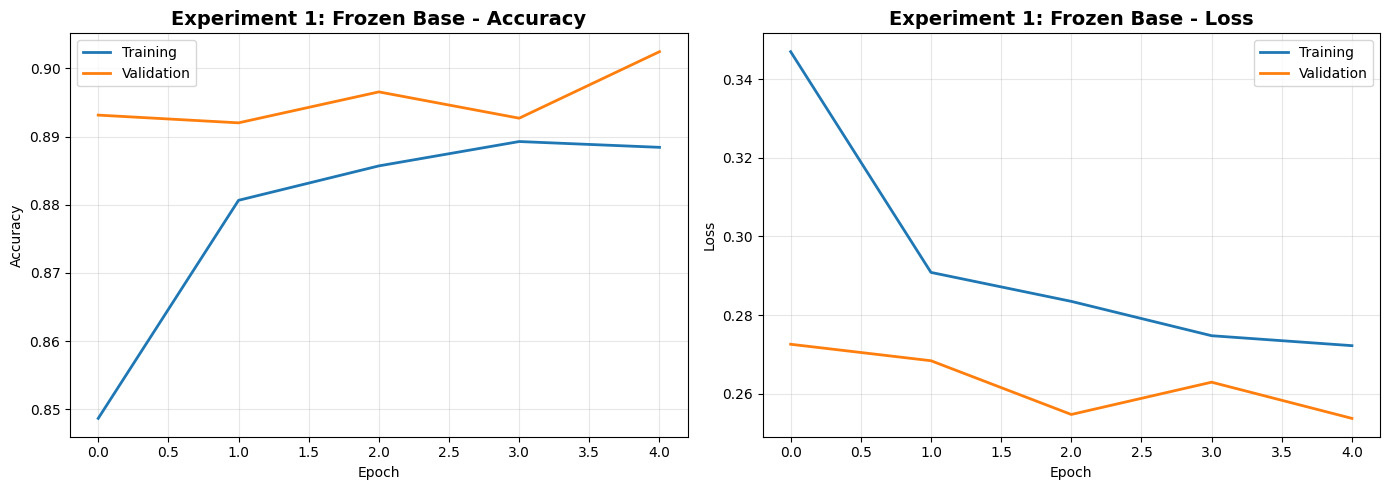

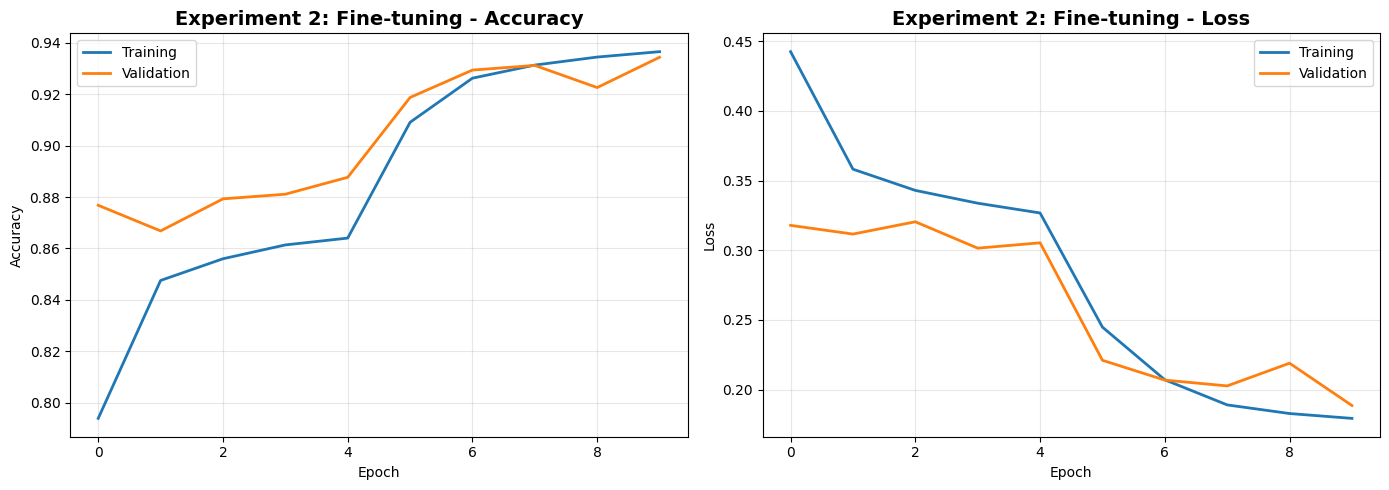

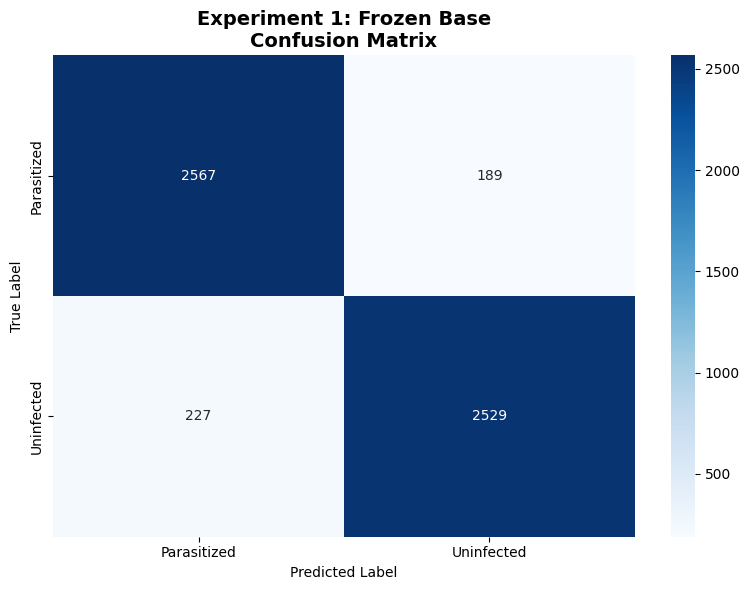

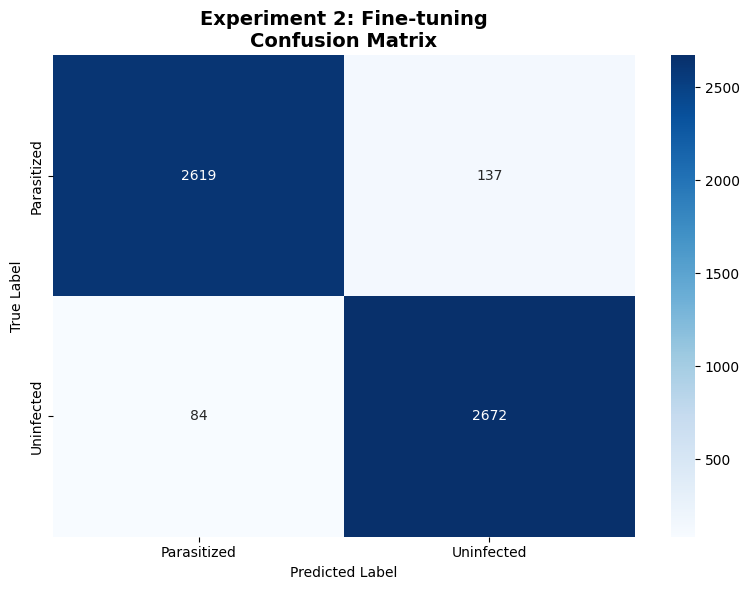

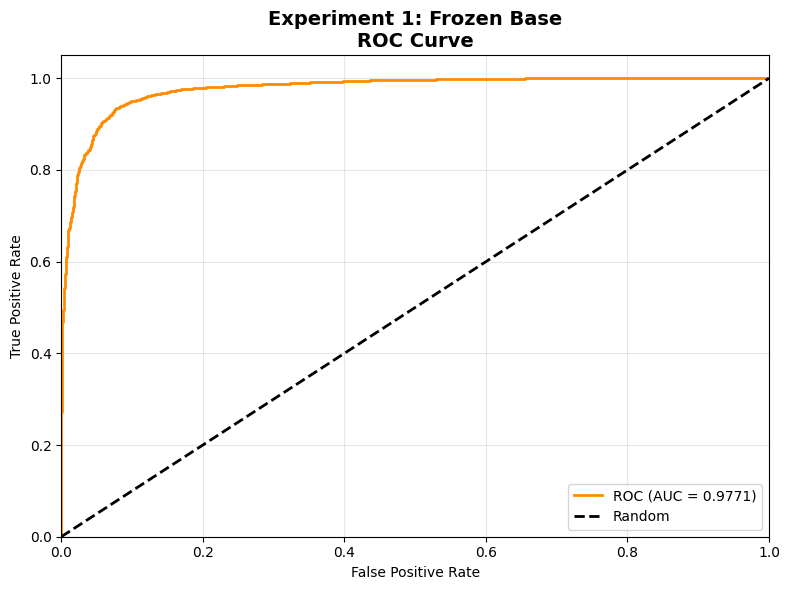

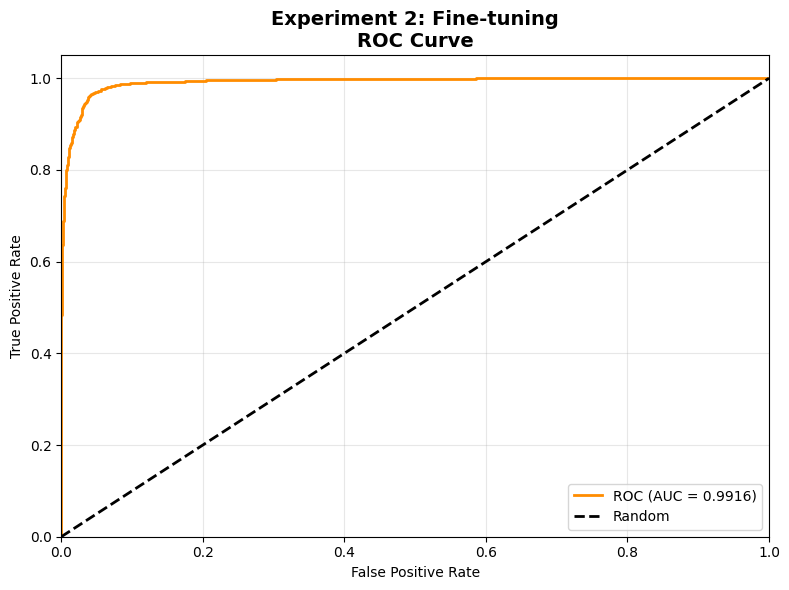

In [15]:
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Get predictions
test_generator.reset()
y_true = test_generator.classes
y_pred_prob_exp1 = model_exp1.predict(test_generator, verbose=0).flatten()
y_pred_exp1 = (y_pred_prob_exp1 > 0.5).astype(int)

test_generator.reset()
y_pred_prob_exp2 = model_exp2.predict(test_generator, verbose=0).flatten()
y_pred_exp2 = (y_pred_prob_exp2 > 0.5).astype(int)

# Learning curves
def plot_learning_curves(history, title, exp_num):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(history['accuracy'], label='Training', linewidth=2)
    axes[0].plot(history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_title(f'{title} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(history['loss'], label='Training', linewidth=2)
    axes[1].plot(history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'inceptionv3_exp{exp_num}_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_learning_curves(history_exp1.history, 'Experiment 1: Frozen Base', 1)
plot_learning_curves(history_exp2, 'Experiment 2: Fine-tuning', 2)

# Confusion matrices
def plot_confusion_matrix(y_true, y_pred, title, exp_num):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Parasitized', 'Uninfected'],
                yticklabels=['Parasitized', 'Uninfected'])
    plt.title(f'{title}\nConfusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'inceptionv3_exp{exp_num}_cm.png', dpi=300, bbox_inches='tight')
    plt.show()
    return cm

cm_exp1 = plot_confusion_matrix(y_true, y_pred_exp1, 'Experiment 1: Frozen Base', 1)
cm_exp2 = plot_confusion_matrix(y_true, y_pred_exp2, 'Experiment 2: Fine-tuning', 2)

# ROC curves
def plot_roc_curve(y_true, y_pred_proba, title, exp_num):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title}\nROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'inceptionv3_exp{exp_num}_roc.png', dpi=300, bbox_inches='tight')
    plt.show()
    return roc_auc

roc_auc_exp1 = plot_roc_curve(y_true, y_pred_prob_exp1, 'Experiment 1: Frozen Base', 1)
roc_auc_exp2 = plot_roc_curve(y_true, y_pred_prob_exp2, 'Experiment 2: Fine-tuning', 2)

# RESULTS TABLE

In [16]:
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

f1_exp1 = 2 * (test_prec_exp1 * test_rec_exp1) / (test_prec_exp1 + test_rec_exp1 + 1e-7)
f1_exp2 = 2 * (test_prec_exp2 * test_rec_exp2) / (test_prec_exp2 + test_rec_exp2 + 1e-7)

results_df = pd.DataFrame({
    'Experiment': ['Exp 1: Frozen Base', 'Exp 2: Fine-tuning'],
    'Accuracy': [f'{test_acc_exp1:.4f}', f'{test_acc_exp2:.4f}'],
    'Precision': [f'{test_prec_exp1:.4f}', f'{test_prec_exp2:.4f}'],
    'Recall': [f'{test_rec_exp1:.4f}', f'{test_rec_exp2:.4f}'],
    'F1-Score': [f'{f1_exp1:.4f}', f'{f1_exp2:.4f}'],
    'AUC': [f'{test_auc_exp1:.4f}', f'{test_auc_exp2:.4f}']
})

print(results_df.to_string(index=False))
print("="*80)

results_df.to_csv('inceptionv3_results.csv', index=False)

# Classification reports
print("\nExperiment 1 Classification Report:")
print(classification_report(y_true, y_pred_exp1,
                          target_names=['Parasitized', 'Uninfected']))

print("\nExperiment 2 Classification Report:")
print(classification_report(y_true, y_pred_exp2,
                          target_names=['Parasitized', 'Uninfected']))

# Error analysis
print("\n" + "="*80)
print("ERROR ANALYSIS")
print("="*80)

def analyze_errors(y_true, y_pred, exp_name):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))

    print(f"\n{exp_name}:")
    print(f"  True Positives:  {tp}")
    print(f"  True Negatives:  {tn}")
    print(f"  False Positives: {fp} (Uninfected as Parasitized)")
    print(f"  False Negatives: {fn} (Parasitized as Uninfected)")
    print(f"  Error Rate: {(fp + fn) / len(y_true):.4f}")

    if fn > fp:
        print("  Warning: High false negatives - missing infections")

    return fp, fn

fp_exp1, fn_exp1 = analyze_errors(y_true, y_pred_exp1, "Experiment 1")
fp_exp2, fn_exp2 = analyze_errors(y_true, y_pred_exp2, "Experiment 2")

print("\n" + "="*80)
print("CONCLUSIONS")
print("="*80)

if test_acc_exp2 > test_acc_exp1:
    print(f"\nExperiment 2 outperforms Experiment 1")
    print(f"Accuracy improvement: {(test_acc_exp2 - test_acc_exp1)*100:.2f}%")
else:
    print(f"\nExperiment 1 performs better")

print(f"Best model: Experiment {2 if test_acc_exp2 > test_acc_exp1 else 1}")
print("\nAll visualizations saved. Training complete!")


FINAL RESULTS SUMMARY
        Experiment Accuracy Precision Recall F1-Score    AUC
Exp 1: Frozen Base   0.9245    0.9305 0.9176   0.9240 0.9766
Exp 2: Fine-tuning   0.9599    0.9512 0.9695   0.9603 0.9908

Experiment 1 Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.92      0.93      0.93      2756
  Uninfected       0.93      0.92      0.92      2756

    accuracy                           0.92      5512
   macro avg       0.92      0.92      0.92      5512
weighted avg       0.92      0.92      0.92      5512


Experiment 2 Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      2756
  Uninfected       0.95      0.97      0.96      2756

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512


ERROR ANALYSIS

Experiment 1:
  True Positives:  2529
  True Nega